This notebook creates a parent strategy(combined) with 2 child strategies(Equal Weight, Inv Vol).

Alternatively, it creates the 2 child strategies, runs the backtest, combines the results, and creates a parent strategy using both of the backtests. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ffn
import bt 

### Create fake data

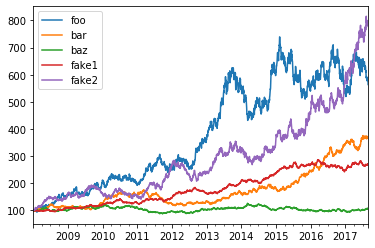

In [8]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05,scale=0.02,size=5) + rf
sigmas = (mus - rf)/0.3 + np.random.normal(loc=0.,scale=0.01,size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year*num_days_per_month

rdf = pd.DataFrame(
    index = pd.date_range(
        start="2008-01-02",
        periods=num_years*num_months_per_year*num_days_per_month,
        freq="B"
    ),
    columns=['foo','bar','baz','fake1','fake2']
)

for i,mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:,i] = np.random.normal(
        loc=mu/num_days_per_year,
        scale=sigma/np.sqrt(num_days_per_year),
        size=rdf.shape[0]
    )
pdf = np.cumprod(1+rdf)*100
pdf.iloc[0,:] = 100

pdf.plot()

In [9]:
strategy_names = np.array(
    [
        'Equal Weight',
        'Inv Vol'
    ]
)

runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True,
    run_on_end_of_period=True
)
selectAllAlgo = bt.algos.SelectAll()
rebalanceAlgo = bt.algos.Rebalance()

strats = []
tests = []

for i,s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = bt.algos.WeighEqually()
    elif s == "Inv Vol":
        wAlgo = bt.algos.WeighInvVol()
    
    strat = bt.Strategy(
        s,
        [
            runMonthlyAlgo,
            selectAllAlgo,
            wAlgo,
            rebalanceAlgo
        ]
    )
    strats.append(strat)
        
    t = bt.Backtest(
        strat,
        pdf,
        integer_positions = False,
        progress_bar=False
    )
    tests.append(t)


In [10]:
combined_strategy = bt.Strategy(
    'Combined',
    algos = [
        runMonthlyAlgo,
        selectAllAlgo,
        bt.algos.WeighEqually(),
        rebalanceAlgo
    ],
    children = [x.strategy for x in tests]
)

combined_test = bt.Backtest(
    combined_strategy,
    pdf,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

Exception: Position is open (non-zero: 204.0816326530612) and latest price is NaN for security Equal Weight on 2008-01-03 00:00:00. Cannot update node value.

In [5]:
res.prices.plot()

NameError: name 'res' is not defined

In [6]:
res.get_security_weights().plot()

NameError: name 'res' is not defined

In order to get the weights of each strategy, you can run each strategy, get the prices for each strategy, combine them into one price dataframe, run the combined strategy on the new data set. 

In [7]:
strategy_names = np.array(
    [
        'Equal Weight',
        'Inv Vol'
    ]
)

runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True,
    run_on_end_of_period=True
)
selectAllAlgo = bt.algos.SelectAll()
rebalanceAlgo = bt.algos.Rebalance()

strats = []
tests = []
results = []

for i,s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = bt.algos.WeighEqually()
    elif s == "Inv Vol":
        wAlgo = bt.algos.WeighInvVol()
    
    strat = bt.Strategy(
        s,
        [
            runMonthlyAlgo,
            selectAllAlgo,
            wAlgo,
            rebalanceAlgo
        ]
    )
    strats.append(strat)
        
    t = bt.Backtest(
        strat,
        pdf,
        integer_positions = False,
        progress_bar=False
    )
    tests.append(t)
    
    res = bt.run(t)
    results.append(res)


C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)
C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


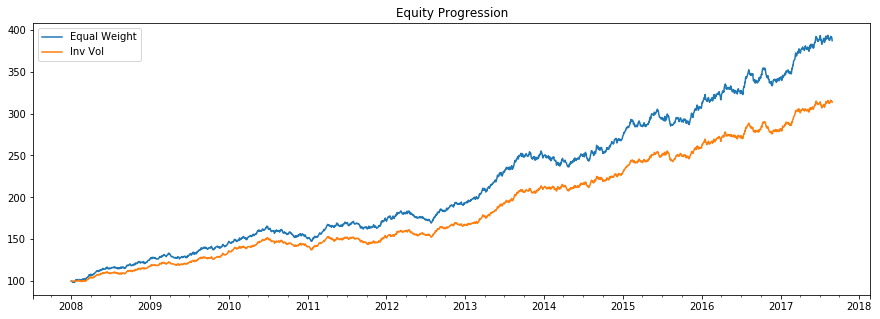

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=1)
for i,r in enumerate(results):
    r.plot(ax=ax)

In [9]:
merged_prices_df = bt.merge(results[0].prices,results[1].prices)

combined_strategy = bt.Strategy(
    'Combined',
    algos = [
        runMonthlyAlgo,
        selectAllAlgo,
        bt.algos.WeighEqually(),
        rebalanceAlgo
    ]
)

combined_test = bt.Backtest(
    combined_strategy,
    merged_prices_df,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)
C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


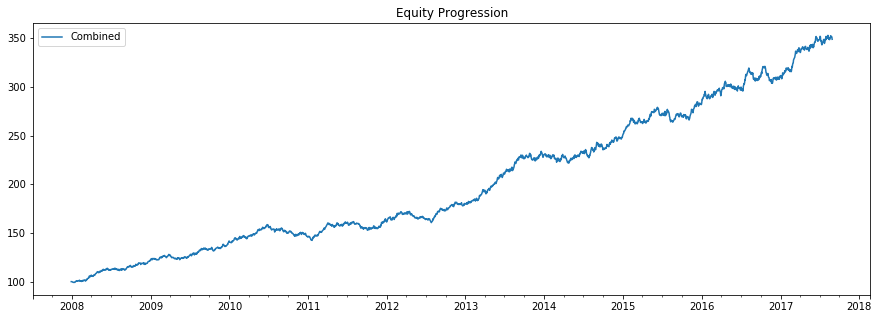

In [10]:
res.plot()

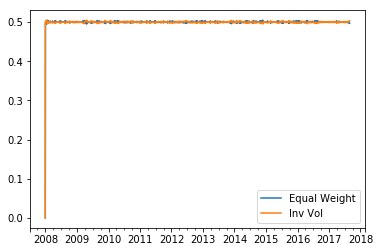

In [11]:
res.get_security_weights().plot()